# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploration of Data

### Profile Data

<strong>profile.json</strong> file includes all demographic data for each customer

Its schema and explanation of each variable:

* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

We can use `describe` method to get more stats about numerical columns

In [2]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


It seems that there are multiple missing values in `gender` and `income` columns

In [3]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


It looks like we haven't formatted the datetime for `became_memeber_on`. Also there is outlier shows the maximum age is 118. We can address these issues more in the next satge for cleaning and transforming data

In [4]:
print("Profile has {} rows and {} columns".format(profile.shape[0], profile.shape[1]))

Profile has 17000 rows and 5 columns


In [5]:
profile.isnull().any()

age                 False
became_member_on    False
gender               True
id                  False
income               True
dtype: bool

It seems that we have couple coulmns have missing values

The outliers in the age histogram and more and more cumstomers become the members year after year. and 2017 is the peak.

However, there is income cut off for each age groups as shown above. For people in 20s and 30s somewhere around 750K is a cut off for example. This indicates that the profile data is arbitrarily created. This may make prediciton simpler because user segmentation is clearler.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd64b5e45f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd64b4d6c50>]], dtype=object)

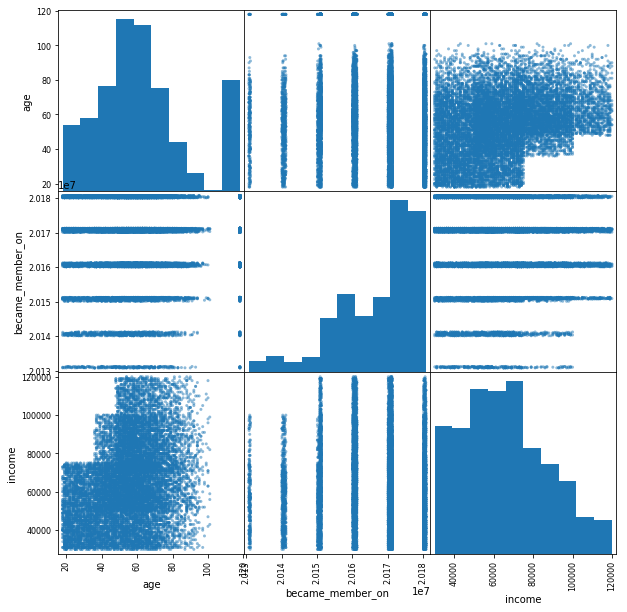

In [6]:
pd.plotting.scatter_matrix(profile,  alpha=0.5, figsize=(10, 10), grid=True)

### Portfolio Data

<strong>portfolio.json</strong> - containing offer ids and meta data about each offer (duration, type, etc.)

Its schema and explanation of each variable:

* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

We can use `describe` method to get more stats about numerical columns

In [7]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [8]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [9]:
print("Portfolio has {} rows and {} columns".format(portfolio.shape[0], portfolio.shape[1]))

Portfolio has 10 rows and 6 columns


In [10]:
portfolio["offer_type"].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

This is a small dataset regarding the offers, which includes 4 discounts, 2 bogos and 2 informational uniquely.

In [11]:
list_channel = []
set([chan for channel in portfolio["channels"].tolist() for chan in channel])

{'email', 'mobile', 'social', 'web'}

There are 4 distinct channels

### Transcript Data

<strong>transcript.json</strong> - records for transactions, offers received, offers viewed, and offers completed

Its schema and explanation of each variable:

* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

We can use `describe` method to get more stats about numerical columns

In [12]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [13]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [14]:
print("Transcript has {} rows and {} columns".format(transcript.shape[0], transcript.shape[1]))

Transcript has 306534 rows and 4 columns


In [15]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

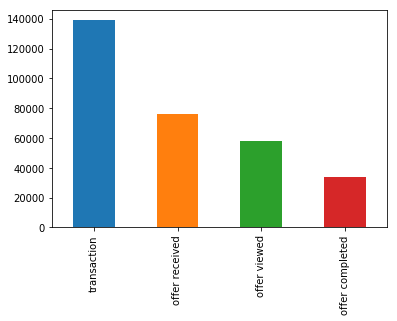

In [16]:
transcript["event"].value_counts().plot(kind="bar")
plt.show()

There is four types of events. Transaction, offer recieved and offer completed. They are reasonably balanced.



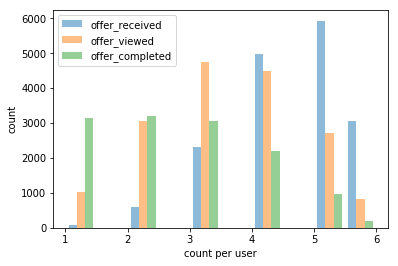

In [17]:
received = transcript[transcript['event']=='offer received'].person.value_counts()
viewed = transcript[transcript['event']=='offer viewed'].person.value_counts()
completed = transcript[transcript['event']=='offer completed'].person.value_counts()

plt.hist([received, viewed, completed], alpha = 0.5, bins=10)
plt.legend(['offer_received', 'offer_viewed', 'offer_completed'])
plt.xlabel('count per user')
plt.ylabel('count')
plt.show()

More members tend to receive and viewed 4 to 5 offers. However, they are most likely complete the first 3 offers. Since most of people are curious about the offers at first. When more and more offers sent to the customers and expired in a validate time period, memebers may not be interested in as before. However, they do view and receive them.

# Data Cleanup and Transformation

### Profile Data

1. previously we noticed that `age` column has 118, which is over 2000 counts out of 17000 total rows. we simply replace them with overall mean. so does `income`.

2. hot-encoding on `gender` column

3. transform the `became_member_on` column to the duration of members as now in datetime format.

In [18]:
def get_dummy_columns_profile(df, column_name, field_name):
    return df[column_name].apply(lambda x: 1 if x == field_name else 0)

In [19]:
import datetime

def profile_cleanup_transform(df):
    p = df.copy()
    p['age'] = p['age'].apply(lambda x: np.nan if x == 118 else x)
    p['age'] = p['age'].fillna(p['age'].mean())
    
    p['income'] = p['income'].fillna(p['income'].mean())
    
    p["male"]   = get_dummy_columns_profile(p, 'gender', 'M')
    p["female"] = get_dummy_columns_profile(p, 'gender', 'F')
    p['not_spicify_gender'] = p['gender'].apply(lambda x: 1 if x != 'F' and x != 'M' else 0)
    p.drop(['gender'], axis=1, inplace=True)

    p['profile_id'] = p['id']
    p.drop(['id'], axis=1, inplace=True)
    p.set_index('profile_id',inplace=True)

    p['member_days'] = (datetime.datetime.today().date() - pd.to_datetime(p['became_member_on'], format='%Y%m%d').dt.date).dt.days
    p.drop(['became_member_on'], axis=1, inplace=True)
    return p

In [20]:
new_profile = profile_cleanup_transform(profile)
new_profile.head()

,age,income,male,female,not_spicify_gender,member_days
profile_id,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,54.393524,65404.991568,0,0,1,1183
0610b486422d4921ae7d2bf64640c50b,55.000000,112000.000000,0,1,0,1030
38fe809add3b4fcf9315a9694bb96ff5,54.393524,65404.991568,0,0,1,668
78afa995795e4d85b5d9ceeca43f5fef,75.000000,100000.000000,0,1,0,1097
a03223e636434f42ac4c3df47e8bac43,54.393524,65404.991568,0,0,1,1010


### Portfolio Data

Since `channel` and `offer_type` are categorical columns, we can convert them into the dummy variable

In [21]:
def get_dummy_columns_portfolio(df, column_name, field_name):
    return df[column_name].apply(lambda x: 1 if field_name in x else 0)

def portfolio_cleanup_transform(df):
    p = df.copy()
    p['web'] = get_dummy_columns_portfolio(p, "channels", "web")
    p['email'] = get_dummy_columns_portfolio(p, "channels", "email")
    p['mobile'] = get_dummy_columns_portfolio(p, "channels", "mobile")
    p['social'] = get_dummy_columns_portfolio(p, "channels", "social")
    p.drop(['channels'], axis=1, inplace=True)
    
    p['bogo'] = get_dummy_columns_portfolio(p, "offer_type", "bogo")
    p['discount'] = get_dummy_columns_portfolio(p, "offer_type", "discount")
    p['informational'] = get_dummy_columns_portfolio(p, "offer_type", "informational")
    p.drop(['offer_type'], axis=1, inplace=True)
    
    p['offer_id'] = p['id']
    p.set_index('offer_id', inplace=True)
    p.drop(['id'], axis=1, inplace=True)
    
    return p

In [22]:
new_portfolio = portfolio_cleanup_transform(portfolio)
new_portfolio.head()

,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
offer_id,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,0,1,1,1,1,0,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,1,0,0,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,1,0,1,0,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,1,0,0,0,1,0


### Transcript Data

1. transform the `value` column and extract the `offer_id`
2. hot-encoding on the `event` column
3. drop off any irrelevant columns

In [23]:
def transaction_cleanup_transform(df):
    p = df.copy()
    p['profile_id'] = p['person']
    p.drop(['person'], axis = 1, inplace = True)

    p['amount'] = p['value'].apply(lambda x: x['amount'])
    p.drop(['value'], axis = 1, inplace = True)
    p.drop(['time'], axis = 1, inplace = True)
    p.drop(['event'], axis = 1, inplace = True)
    
    p.reset_index(drop=True, inplace = True)
    return p

def offer_cleanup_transform(df):
    p = df.copy()
    p['profile_id'] = p['person']
    p.drop(['person'], axis = 1, inplace = True)
    
    p['offer_id'] = p['value'].apply(lambda x: x['offer id'] if 'offer id' in x.keys() else x['offer_id'] if 'offer_id' in x.keys() else np.nan)

    p['event'] = p['event'].apply(lambda x: x.replace(" ", "_"))                                 
    event_df = pd.get_dummies(p['event'])    
    p = pd.concat([p, event_df], axis=1)

    p.drop(['value', 'time', 'event'], axis = 1, inplace = True)
    p.reset_index(drop=True, inplace = True)
    return p

In [24]:
transaction = transcript[transcript["event"] == "transaction"].copy()
new_transaction = transaction_cleanup_transform(transaction)
new_transaction.head()

,profile_id,amount
0,02c083884c7d45b39cc68e1314fec56c,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56
2,54890f68699049c2a04d415abc25e717,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,18.97


In [25]:
offer = transcript[transcript["event"] != "transaction"].copy()
new_offer = offer_cleanup_transform(offer)
new_offer.head()

,profile_id,offer_id,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


###  Merge Data

In [28]:
merged_data = pd.merge(new_offer, new_portfolio, on='offer_id')
merged_data = pd.merge(merged_data, new_profile, on='profile_id')

columns = merged_data.columns
list(columns)

offer_columns = ['offer_completed', 'offer_received', 'offer_viewed']

agg_func={}
for x in columns:
    if x in offer_columns:
        agg_func[x] = "sum"
    elif x not in ['profile_id', 'offer_id']:
        agg_func[x] = "mean"

grouped_data = merged_data.groupby(['profile_id', 'offer_id']).agg(agg_func)

grouped_data['offer_completed'] = grouped_data['offer_completed'].apply(lambda x: 1 if x > 0.0 else 0)

grouped_data.reset_index(inplace=True, drop=True)

offer_received = grouped_data['offer_received']
offer_viewed = grouped_data['offer_viewed']
offer_completed = grouped_data['offer_completed']

X = grouped_data.drop([
    'offer_completed', 
    'offer_received',
    'offer_viewed',], axis = 1)

In [29]:
X.head()

,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational,age,income,male,female,not_spicify_gender,member_days
0,10,7,2,1,1,1,0,0,1,0,33.0,72000.0,1,0,0,1115
1,0,4,0,1,1,1,0,0,0,1,33.0,72000.0,1,0,0,1115
2,0,3,0,0,1,1,1,0,0,1,33.0,72000.0,1,0,0,1115
3,5,5,5,1,1,1,1,1,0,0,33.0,72000.0,1,0,0,1115
4,10,10,2,1,1,1,1,0,1,0,33.0,72000.0,1,0,0,1115


### Normalize Grouped Data 

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical = ['age', 'income', 'difficulty','duration', 'reward','member_days']

X[numerical] = scaler.fit_transform(X[numerical])
X.head()

,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational,age,income,male,female,not_spicify_gender,member_days
0,0.50,0.571429,0.2,1,1,1,0,0,1,0,0.180723,0.466667,1,0,0,0.25288
1,0.00,0.142857,0.0,1,1,1,0,0,0,1,0.180723,0.466667,1,0,0,0.25288
2,0.00,0.000000,0.0,0,1,1,1,0,0,1,0.180723,0.466667,1,0,0,0.25288
3,0.25,0.285714,0.5,1,1,1,1,1,0,0,0.180723,0.466667,1,0,0,0.25288
4,0.50,1.000000,0.2,1,1,1,1,0,1,0,0.180723,0.466667,1,0,0,0.25288


### Split the Data

In [31]:
from sklearn.model_selection import train_test_split

def split_data(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=1)
    return X_train, X_test, y_train, y_test


In [32]:
X_train, X_test, y_train, y_test = split_data(X, offer_completed, 0.2)

# Benchmark Model

In [33]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score

In [34]:
def train_and_prediction(model, X_train, y_train, X_test, y_test):
    print('Name: {}'.format(model.__class__.__name__))
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = model.score(X_test, y_test)
    print('Test score: {:.3f}'.format(score))
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy score: {:.3f}'.format(accuracy))

    probs = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probs)
    print('AUC: %.2f' % auc)
    fpr, tpr, _ = roc_curve(y_test, probs)
    
    confusionMatrix = confusion_matrix(y_test, y_pred)
    
    return {'y_pred': y_pred, 'auc': auc, 'fpr': fpr, 'tpr': tpr, 'score': score, 'accuracy': accuracy, "confusion_matrix": confusionMatrix}

In [35]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy="most_frequent")

In [36]:
train_and_prediction(model, X_train, y_train, X_test, y_test)

Name: DummyClassifier
Test score: 0.542
Accuracy score: 0.542
AUC: 0.50


{'y_pred': array([0, 0, 0, ..., 0, 0, 0]),
 'auc': 0.5,
 'fpr': array([ 0.,  1.]),
 'tpr': array([ 0.,  1.]),
 'score': 0.54163374940748932,
 'accuracy': 0.54163374940748932,
 'confusion_matrix': array([[6856,    0],
        [5802,    0]])}

When using the DummyClassifer as a benchmark model, it will generate the AUC score for 50%, which the base model 

# Experiment with other Classifiers

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

models = []
models.append(DummyClassifier(strategy="most_frequent"))
models.append(SVC(probability=True))
models.append(MLPClassifier())
models.append(LogisticRegression())
models.append(KNeighborsClassifier())
models.append(SVC(kernel='linear',probability=True))
models.append(RandomForestClassifier())
models.append(AdaBoostClassifier())

Name: DummyClassifier
Test score: 0.542
Accuracy score: 0.542
AUC: 0.50
Name: SVC
Test score: 0.767
Accuracy score: 0.767
AUC: 0.86
Name: MLPClassifier
Test score: 0.781
Accuracy score: 0.781
AUC: 0.88
Name: LogisticRegression
Test score: 0.765
Accuracy score: 0.765
AUC: 0.85
Name: KNeighborsClassifier
Test score: 0.764
Accuracy score: 0.764
AUC: 0.84
Name: SVC
Test score: 0.766
Accuracy score: 0.766
AUC: 0.85
Name: RandomForestClassifier
Test score: 0.758
Accuracy score: 0.758
AUC: 0.84
Name: AdaBoostClassifier
Test score: 0.782
Accuracy score: 0.782
AUC: 0.88


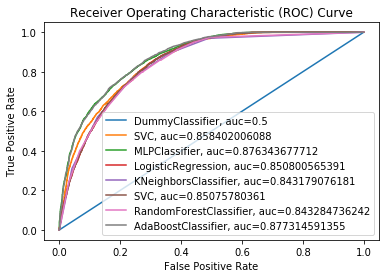

---------------------------------
best_method： AdaBoostClassifier
best_score： 0.781640069521


In [38]:
best_score = 0
best_method = ""

for model in models:
    result = train_and_prediction(model, X_train, y_train, X_test, y_test)
    fpr, tpr, auc = result['fpr'], result['tpr'], result['auc']
    plt.plot(fpr,tpr,label="{}, auc={}".format(model.__class__.__name__, str(auc)))
    
    if result['score'] > best_score:
        best_method = model.__class__.__name__
        best_score = result['score']

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print('---------------------------------')
print('best_method：', best_method)
print('best_score：', best_score)

The best model is Adaboost, which has AUC score 78.2%  and neural network model has AUC score 78.1%. Also, both Adaboost and NN model have the same accuracy scores, which are 0.88. As we know, NN model is very good at capturing the non-linear relationship between data, which is a overkill here. I am very satisfy with the ensemble model to acheieve a slightly better result than NN model

I have been using the supervised learning algorithms to classcify the relationship between user behavior and offer completed. However, as I said, this project is a open problem. We can also use the unsupervised learning techniques to cluster the user groups in response offer types based on their behavior